# Image analysis with scikit-image

Hyperspy and its associated packages has a lot of functionality for analysis of (electron microscopy) images, but of course not every analysis task is available. In this notebook, we create a custom image analysis algorithm using the Python libraries NumPy, SciPy and scikit-image. The algorithm we will create finds defects in noisy contaminated graphene images using thresholding, Bragg filtering and blob detection. The dataset we analyse is a subset of the STEM-MAADF images collected as part of an automated scan map by Alberto Trentino, the data was originally published [here](https://pubs.acs.org/doi/full/10.1021/acs.nanolett.1c01214). It is noted that the selection of images were deliberately chosen to have contamination.

### Authors:
* 16/05/2024 Jacob Madsen - For the HyperSpy workshop at ePSIC 2024

In [35]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.colors import LogNorm

import skimage
import scipy
import hyperspy.api as hs

## Importing images

We import the image using the [skimage.io](https://scikit-image.org/docs/stable/api/skimage.io.html) module, the image is imported as a NumPy array. Of course HyperSpy can be used as well, and would be necessary for specialized image formats.

In [2]:
fname = "data/stem_maadf_scan_map_0000.tif"

image = skimage.io.imread(fname)
image = hs.load(fname).data

image.shape, image.dtype

((1024, 1024), dtype('float32'))

## Binning and rescaling

We downscale the image using binning with [downscale_local_mean](https://scikit-image.org/docs/stable/api/skimage.transform.html#skimage.transform.downscale_local_mean). We use binning instead of [rescaling](https://scikit-image.org/docs/stable/auto_examples/transform/plot_rescale.html) to avoid aliasing artifacts. 

In [3]:
binned_image = skimage.transform.downscale_local_mean(image, (2, 2))

image.shape, binned_image.shape

((1024, 1024), (512, 512))

## Displaying images with Matplotlib

We can use the Matplotlib library to inspect the images. By default the image is normalized such that the full range is displayed, we can change that by changing `vmin` and `vmax`. We can also display the image on a powerscale to enhance lower intensities (equivalent to `gamma` in image-jargon). 

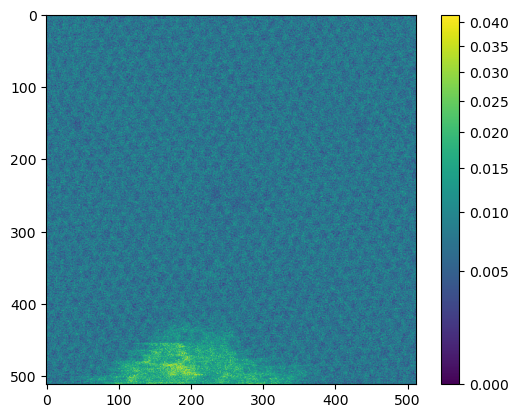

In [4]:
plt.figure()
plt.imshow(binned_image, norm=matplotlib.colors.PowerNorm(.5))
plt.colorbar()

If we are unhappy with the default colormap it can be changed globally by setting `matplotlib.rc`. Other settings such as image size can also be changed globally in this way.

In [5]:
matplotlib.rc("image", cmap="gray")

## FFTs and displaying reciprocal space images
Performing FFT's and understanding how to manipulate images in both real and reciprocal space is an important aspect of image analysis in electron microscopy.

We use NumPy to Fourier transform the image.

In [6]:
fft_image = np.fft.fft2(binned_image)

fft_image.shape, fft_image.dtype

((512, 512), dtype('complex128'))

The Fourier transformed image is complex and the zero-frequency is at the upper left corner. We take the amplitude and shift the zero-frequency to the center. We make the code into a function as we will need it later.

In [7]:
power_spectrum = np.fft.fftshift(np.abs(fft_image))

In [8]:
def calculate_power(image):
    fft_image = np.fft.fft2(image)
    return np.fft.fftshift(np.abs(fft_image))

Images are typically dominated by the low frequencies, hence it may be necessary to display them in reciprocal space using a logarithmic normalization.

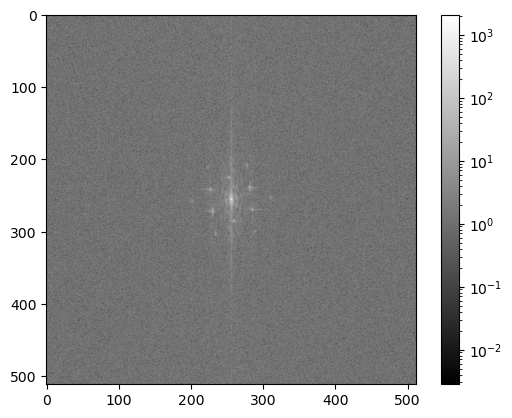

In [9]:
plt.figure()
plt.imshow(power_spectrum, norm=LogNorm())
plt.colorbar()

## Filtering
Filtering is the most basic method of removing noise. This is typically utilizing that the noise has a larger frequency than the signal and thus we can remove the high frequencies without damaging the signal.

scikit-image has a large selection of filters, see [documentation](https://scikit-image.org/docs/stable/api/skimage.filters.html#skimage.filters.difference_of_gaussians) and [examples](https://scikit-image.org/docs/stable/auto_examples/index.html#filtering-and-restoration).

We will just use a Gaussian filter, i.e. higher frequencies are attenuated weighted according to a Gaussian. 

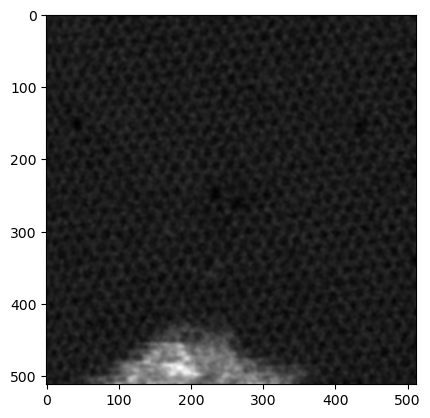

In [10]:
filtered_image = skimage.filters.gaussian(binned_image, 2)

plt.figure()
plt.imshow(filtered_image)

We see that the Gaussian filter attenuated the larger frequencies while preserving the lower. The streaks are mainly due to the contamination introducing discontinuous step in the signal.  

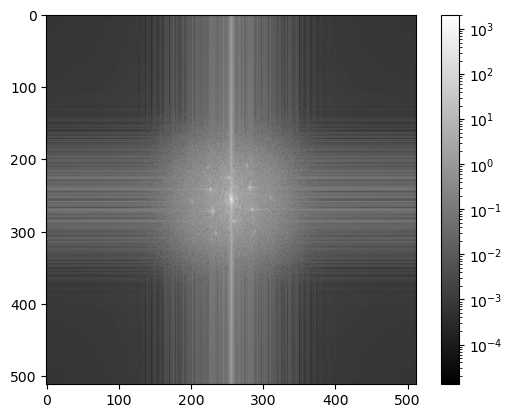

In [11]:
power_spectrum = calculate_power(filtered_image)

plt.figure()
plt.imshow(power_spectrum, norm=LogNorm())
plt.colorbar()

## Histogram thresholding

The most basic method of segmenting the contamination is histogram thresholding, i.e. selecting the pixels with a value above (or below) a specified threshold. 

We start by showing a histogram of the image values.

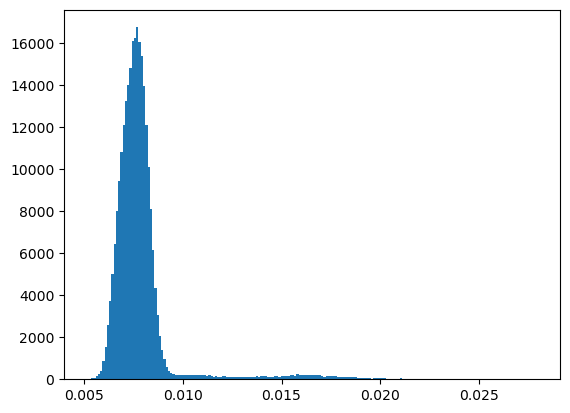

In [12]:
plt.hist(filtered_image.ravel(), bins=200, cumulative=False);

scikit-image provides several methods for automatically selecting an optimal threshold. The methods typically attempts to the find the threshold that "best" separates the histogram into two different modes. See the documentation for a comprehensive [example](https://scikit-image.org/docs/stable/auto_examples/applications/plot_thresholding_guide.html#sphx-glr-auto-examples-applications-plot-thresholding-guide-py).

The `try_all_threshold` function will apply each of the different methods and show a visualization of the result.

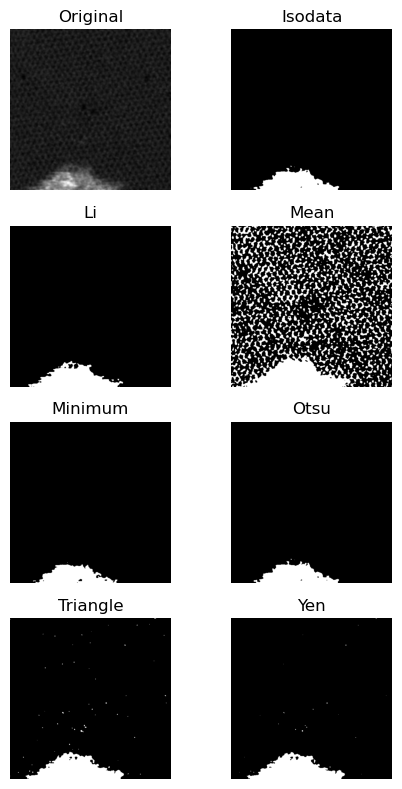

In [13]:
from skimage.filters import try_all_threshold

skimage.filters.try_all_threshold(filtered_image, figsize=(5, 8), verbose=False);

Based on the visualization most of the methods seems to work reasonably well, we will pick the "Yen" method.

In [14]:
threshold = skimage.filters.threshold_yen(filtered_image)

print(threshold)

contamination = filtered_image > threshold

0.00944666


Finally, we can show the thresholded image, i.e. the segmented contamination. We use the alpha keyword to overlay the contamination on the image.

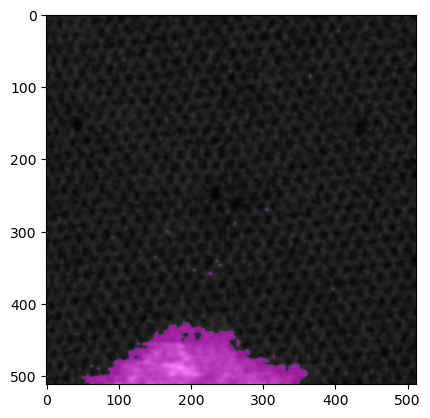

In [15]:
fig = plt.figure()
plt.imshow(filtered_image)
plt.imshow(contamination, cmap="cool", alpha=contamination.astype(float) * .5)

## Morphological transformations

Often segmentations based on thresholding may produce a noisy output. Binary masks can be manipulated using morphological transformations, see the [module documentation](https://scikit-image.org/docs/stable/api/skimage.morphology.html#module-skimage.morphology) or this [example](https://scikit-image.org/docs/stable/auto_examples/applications/plot_morphology.html). 

To clean up the segmented contamination, we remove the small holes and objects, then, we expand the contamination using dilation.

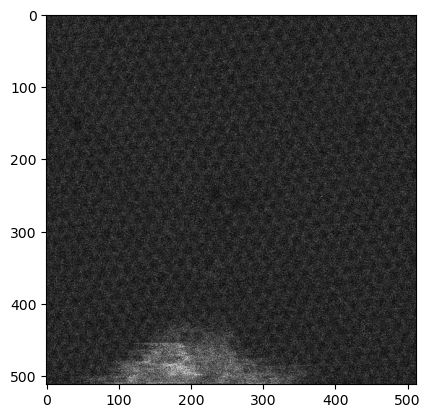

In [16]:
cleaned_contamination = skimage.morphology.remove_small_holes(contamination, 64)
cleaned_contamination = skimage.morphology.remove_small_objects(cleaned_contamination, 64)

disk = skimage.morphology.disk(15)
cleaned_contamination = skimage.morphology.binary_dilation(cleaned_contamination, disk)

fig = plt.figure()
plt.imshow(binned_image)
#plt.imshow(cleaned_contamination, cmap="cool", alpha=cleaned_contamination.astype(float) * .5)

## Masking images
We mask the image by setting the values of the contamination mask to the mean image value.

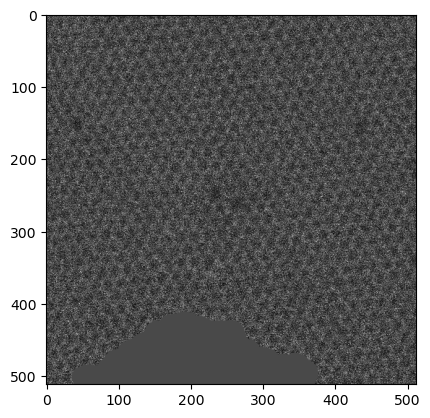

In [17]:
masked_image = binned_image.copy()

masked_image[cleaned_contamination] = masked_image[cleaned_contamination == 0].mean()

plt.figure()
plt.imshow(masked_image)

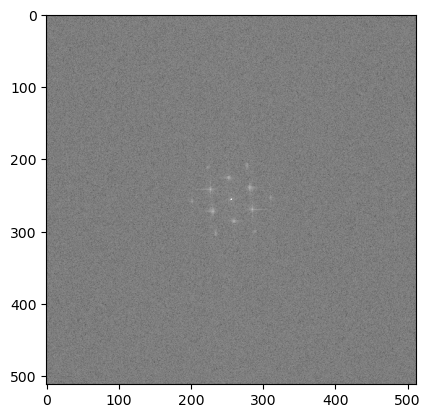

In [18]:
power_spectrum = calculate_power(masked_image)

plt.figure()
plt.imshow(power_spectrum, norm=matplotlib.colors.LogNorm())

## Windowed FFT

The remaining streaks around the diffraction spots in the power spectrum comes from the discontinuities at the boundary of the image. They can be removed by applying a [window function](https://en.wikipedia.org/wiki/Window_function) to the original signal before computating of the FFT. See also example in [documentation](https://scikit-image.org/docs/stable/auto_examples/filters/plot_window.html#sphx-glr-auto-examples-filters-plot-window-py).

The `skimage.filters.window` module has a multiple of available window functions, see [docs](https://docs.scipy.org/doc/scipy/reference/signal.windows.html). Here, we choose a Hanning window, this is also default when setting `apodization = True` using the [FFT](http://hyperspy.org/hyperspy-doc/current/api/hyperspy.signal.html#hyperspy.signal.BaseSignal.fft) method of a HyperSpy signal.

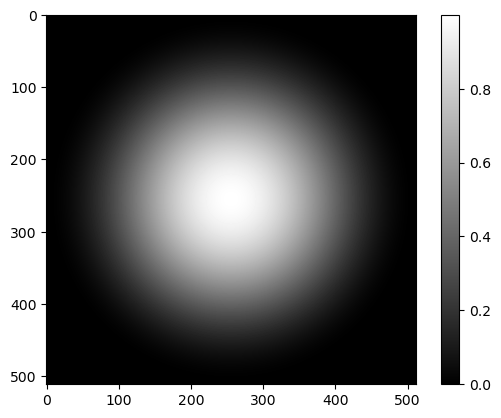

In [19]:
hanning = skimage.filters.window("hann", binned_image.shape)

plt.figure()
plt.imshow(hanning)
plt.colorbar();

We multiply the image by the window function in real space.

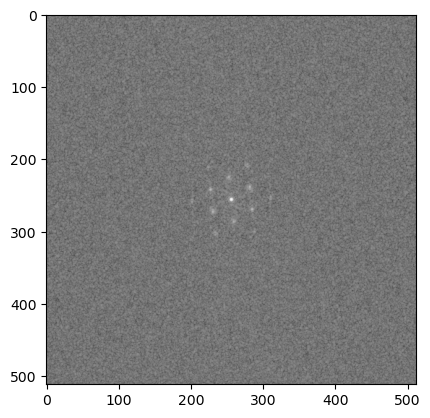

In [20]:
windowed_power = calculate_power(masked_image * hanning)

plt.figure()
plt.imshow(windowed_power, norm=LogNorm())

### Find diffraction spots
With our clean power spectrum it is much easier to find the diffraction spots.

The `skimage.feature.peak_local_max` function returns the coordinates of local peaks (maxima) in an image. A minimum distance between the detected peaks is given to avoid detecting the same peak multiple times.

In [21]:
coordinates = skimage.feature.peak_local_max(windowed_power, min_distance=20)

Plotting the detected peaks, we see that, in addition to the diffraction spots, a lot of unwanted peaks in the random noise was found.

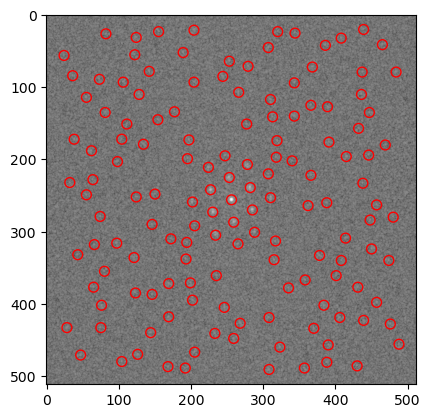

In [22]:
plt.figure()
plt.imshow(windowed_power, norm=LogNorm())
plt.scatter(coordinates[:,1], coordinates[:,0], s = 50, facecolors = 'none', edgecolors = 'r');

We expect the most intense peak to be the zero'th order spot, the next six peaks will be the first order spots. Hence, we may select these spots by slicing the array of coordinates from index 1 through 13. 

The positions of diffraction spots are overlaid on the power spectrum.

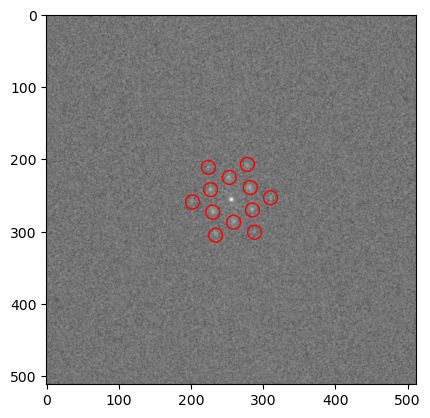

In [23]:
selected_coordinates = coordinates[1:13]

plt.figure()
plt.imshow(windowed_power, norm=LogNorm())
plt.scatter(selected_coordinates[:,1], selected_coordinates[:,0], s = 100, facecolors = 'none', edgecolors = 'r');

### Create Bragg mask

The Bragg mask will be an array with zeros everywhere except for the regions around the first order diffraction spots. 

We start by creating an array of zeros and set the pixels at the diffraction spots to 1, i.e. the array represents a set of delta-functions placed at the positions of the Bragg spots.

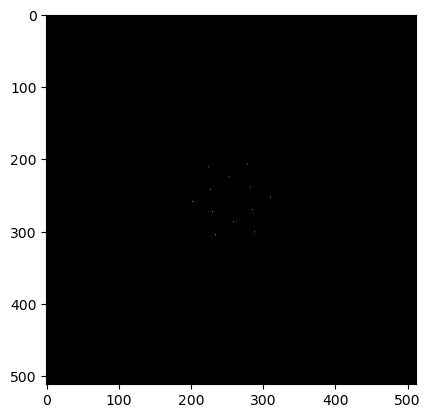

In [24]:
delta_mask = np.zeros_like(windowed_power, dtype=float)

delta_mask[selected_coordinates[:,0], selected_coordinates[:,1]] = 1

plt.figure()
plt.imshow(delta_mask);

To finalize the Bragg mask, we convolve a disk with the array with the delta-functions.

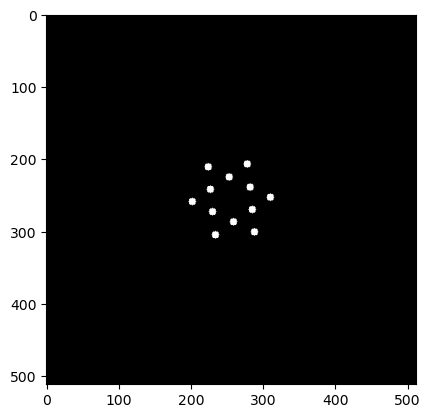

In [25]:
disk = skimage.morphology.disk(5)

mask = scipy.signal.fftconvolve(delta_mask, disk, mode='same')

plt.figure()
plt.imshow(mask);

Note that the Bragg mask could possibly be improved slightly making the edges of the disks smoother.

### Apply Bragg filter 

We apply the Bragg mask to the Fourier transformed image. Here, we do not use windowing and we make sure to inverse shift the mask.

In [26]:
bragg_filtered = np.fft.ifft2(np.fft.fft2(binned_image) * np.fft.ifftshift(mask)).real

The result is complex-valued, to get the Bragg filtered image we select the real part.

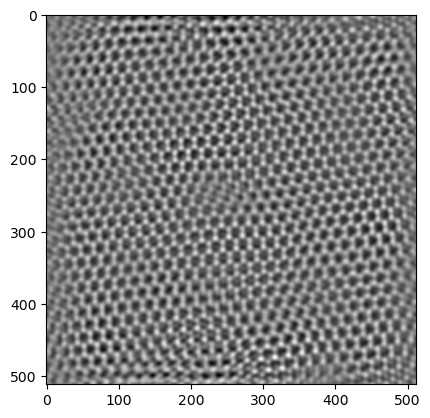

In [27]:
plt.figure()
plt.imshow(bragg_filtered);

The Bragg filtered image shows a perfect graphene lattice. The trick to using Bragg filtering to finding the defects is to subtract the original image from the periodic Bragg filtered image to obtaini the non-periodic components.

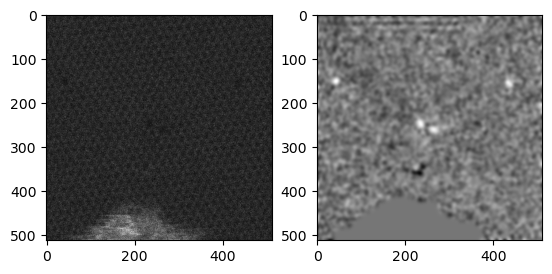

In [28]:
non_periodic = bragg_filtered.real - binned_image

non_periodic[cleaned_contamination] = non_periodic[cleaned_contamination == 0].mean()

non_periodic = skimage.filters.gaussian(non_periodic.real, 4)

fig, (ax1, ax2) = plt.subplots(1,2)
ax1.imshow(binned_image);
ax2.imshow(non_periodic);

### Blob detection

The image above should show the defects as bright "blobs" on a noisy background. We will use the scikit-image implementation of the "Laplacian-of-Gaussian" (LOG) blob detection algorithm. See the [docs](https://scikit-image.org/docs/stable/auto_examples/features_detection/plot_blob.html) for an example or the [wiki page](https://en.wikipedia.org/wiki/Blob_detection) for a theoretical description.

We use the scikit-image implementation of the LOG algorithm to find the blobs, the parameters are explained in the [docs](https://scikit-image.org/docs/stable/api/skimage.feature.html#skimage.feature.blob_log). Finding the right parameters 

In [29]:
blobs_log = skimage.feature.blob_log(non_periodic, 
                                     min_sigma = 10,
                                     max_sigma = 15, 
                                     threshold = .0004,
                                     exclude_border = 20)

Selecting the optimal parameters for the blob detection algorithm is not always trivial. You might even want to use some machine learning methods to find the best parameters. 

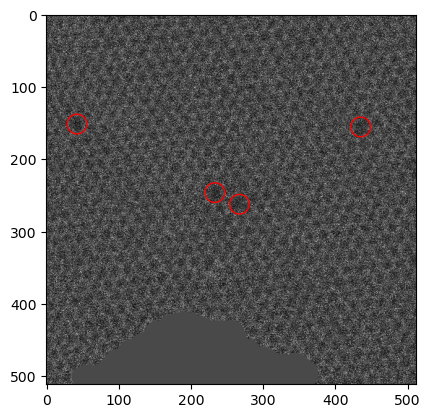

In [30]:
plt.figure()
plt.imshow(masked_image);
plt.scatter(blobs_log[:,1], blobs_log[:,0], s = 200, facecolors = 'none', edgecolors = 'r');

## Applying algorithm to image series

The next step is ensure that the algorihm works on other images. When we are confident that the algorithm is robust, we can run it across our entire dataset. However, doing so with a Jupyter notebook, one image at a time, is quite inefficient (although we could use [papermill](https://papermill.readthedocs.io/en/latest/)). 

Writing an algorithm step-by-step in a Jupyter notebook is great for prototyping; however, once you have a working algorithm you should create proper python functions (preferably with documentation). Below the code in this Jupyter notebook is made into functions.

In [31]:
def import_binned_image(fname, binning=(2,2)):
    image = skimage.io.imread(fname)
    image = skimage.transform.downscale_local_mean(image, binning)
    return image

def calculate_power_spectrum(image):
    fft_image = np.fft.fft2(image)
    return np.fft.fftshift(np.abs(fft_image))

def segment_contamination(image, sigma=2, area_threshold=128, dilation=15):
    image = skimage.filters.gaussian(image, sigma)
    threshold = skimage.filters.threshold_yen(image)
    contamination = image > threshold
    contamination = skimage.morphology.remove_small_holes(contamination, area_threshold)
    contamination = skimage.morphology.remove_small_objects(contamination, area_threshold)
    disk = skimage.morphology.disk(dilation)
    return skimage.morphology.binary_dilation(contamination, disk)

def mask_image(image, mask):
    masked_image = image.copy()
    masked_image[mask] = masked_image[mask == 0].mean()
    return masked_image

def windowed_power_spectrum(image):
    hanning = skimage.filters.window("hann", image.shape)
    return calculate_power_spectrum(masked_image * hanning)

def find_diffraction_spots(image, num_spots=6, min_distance=20):
    power = windowed_power_spectrum(image)
    coordinates = skimage.feature.peak_local_max(power, min_distance=min_distance)
    return coordinates[1:num_spots+1]

def create_bragg_mask(spots, shape, disk_radius):
    delta_mask = np.zeros(shape, dtype=float)
    delta_mask[spots[:,0], spots[:,1]] = 1
    disk = skimage.morphology.disk(disk_radius).astype(float)
    return scipy.signal.fftconvolve(delta_mask, disk, mode='same')

def apply_fft_filter(image, mask):
    return np.fft.ifft2(np.fft.fft2(image) * np.fft.ifftshift(mask)).real

We can now import a series of images and apply our algorithm to each of them.

In [32]:
import glob

image_names = sorted(glob.glob("data/*.tif"))
image_names

['data\\stem_maadf_scan_map_0000.tif',
 'data\\stem_maadf_scan_map_0001.tif',
 'data\\stem_maadf_scan_map_0002.tif']

We loop over all the file_names and visualize the output.

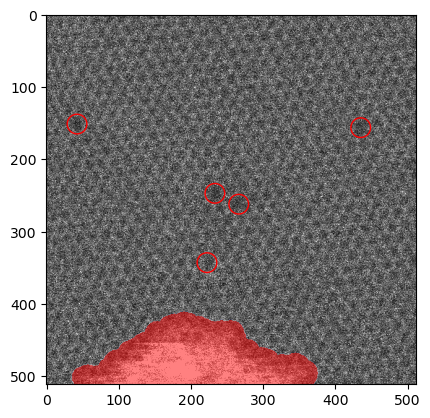

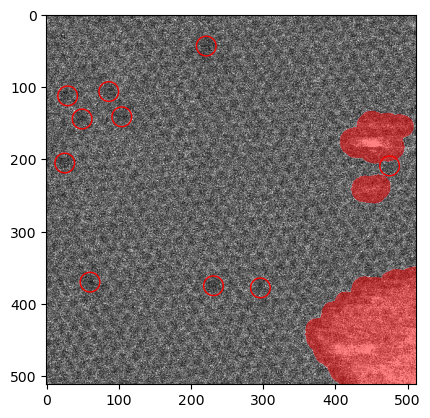

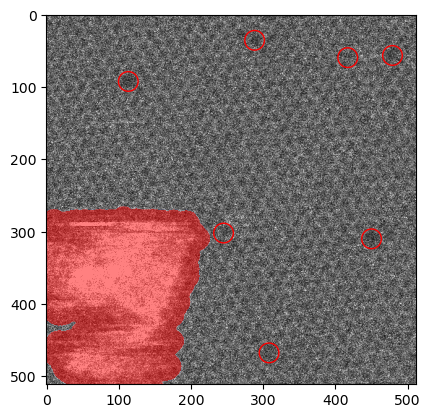

In [33]:
for fname in image_names:
    image = import_binned_image(fname, binning=(2,2))

    contamination = segment_contamination(image, sigma=2, area_threshold=128, dilation=15)
    
    masked_image = mask_image(image, contamination)
    
    spots = find_diffraction_spots(masked_image, num_spots=6, min_distance=20)
    
    bragg_mask = create_bragg_mask(spots, image.shape, disk_radius=5)
    
    bragg_filtered = apply_fft_filter(image, bragg_mask)
    
    non_periodic = bragg_filtered - image
    
    non_periodic = mask_image(non_periodic, contamination)
    
    blobs_log = skimage.feature.blob_log(non_periodic, 
                                         min_sigma = 10,
                                         max_sigma = 15,
                                         threshold = .0004,
                                         exclude_border = 20)
    
    plt.figure()
    plt.imshow(image, vmax=.018)
    plt.scatter(blobs_log[:,1], blobs_log[:,0], s = 200, facecolors = 'none', edgecolors = 'r')
    plt.imshow(contamination, cmap="bwr", alpha=contamination.astype(float) * .5)